In [2]:
# Import packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import glob
import os
from numpy.random import seed
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats
import random
from sklearn.metrics import mean_squared_error
import timeit

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [3]:
# Prior data wrangling notebook ends with a csv save of train_master dataset. Load dataset here.
train_csv = "train_master.csv"
dates = ['TIME_SCHEDULED',
         'ARRIVAL',
         'DEPARTURE',
         'Date',
         'SURVEY_DATE_EFFECTIVE',
         'BRONCOS_TIME']
trains = pd.read_csv(train_csv,
                    header=0,
                     sep=',',
                     index_col=0,
                     infer_datetime_format=True,
                     parse_dates=dates)
trains.sort_values(by=['TIME_SCHEDULED'],inplace=True)
trains.info(verbose=True, null_counts=True)

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (49,50,51,52,53,54,55,56,57,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838225 entries, 0 to 1838221
Data columns (total 103 columns):
SERIAL_NUMBER                           1838225 non-null int64
SCHEDULE_NAME                           1838225 non-null object
SIGNUP_NAME                             1838225 non-null object
SURVEY_SOURCE                           1838225 non-null int64
PATTERN_ID                              1838225 non-null int64
BRANCH                                  1838225 non-null object
ROUTE_NUMBER                            1838225 non-null int64
ROUTE_NAME                              1838225 non-null object
DIRECTION_NAME                          1838225 non-null object
SERVICE_TYPE                            1838225 non-null object
SERVICE_MODE                            1836357 non-null object
SURVEY_DATE_EFFECTIVE                   1838225 non-null datetime64[ns]
SURVEY_DATE_ATYPICAL                    1838225 non-null int64
TIME_PERIOD                             1838225 non

In [4]:
# Remove records corresponding to the final stop of a route
trains = trains.loc[trains.END_OF_LINE == 0]

Add prior delays to the dataset, indicating the departure delay at prior 1st, 2nd, 3rd, and 4th station.

In [5]:
def prior_delay(df,shift_value):
    """
       Returns dataframe and correlation of previous (n) station's delay and current delay.
    
       Parameters:
       df: train station data that must include SERIAL_NUMBER, TIME_SCHEDULED, DEPARTURE_DELAY, and END_OF_LINE
       shift_value: represents n stations in past
    
    """  
    # Sort values by serial number and time scheduled and reset index
    df = df.sort_values(by=['SERIAL_NUMBER','TIME_SCHEDULED'])
    df.reset_index(inplace=True)
    
    # Create a smaller dataframe with delay and matching fields
    df_shifted = df[['SERIAL_NUMBER','DEPARTURE_DELAY']].shift(shift_value)
    
    # Create a new field to capture the prior n delay
    new_field = 'prior_departure_delay'+'_'+str(shift_value)
    df_shifted.columns=['SERIAL_NUMBER',new_field]
      
    # Merge the reduced dataframe into the master matching indeces and ensuring serial numbers match
    df = pd.merge(df,
                 df_shifted,
                 #on='SERIAL_NUMBER',
                 left_index=True,
                 right_index=True,
                 how='left')
    
    # Replace NaN fields with 0 as previous delays at non-existent trains would effectively be 0
    df[new_field].fillna(0, inplace=True)
    
    # Iterate over rows to identify prior delays pulled from mismatched serial number
    for index, row in df.iterrows():
        prior_index = index - shift_value
        if prior_index >=0:
            if row['SERIAL_NUMBER_x'] != df.at[prior_index, 'SERIAL_NUMBER_x']:
                df.at[index,new_field] = 0
    
    # Drop the extraneous SERIAL_NUMBER FIELD and set original SERIAL_NUMBER to original format
    df = df.drop(['SERIAL_NUMBER_y'], axis=1)
    df = df.rename(columns={'SERIAL_NUMBER_x':'SERIAL_NUMBER'})
    df =  df[df.columns.drop(list(df.filter(regex='index')))]
    df =  df[df.columns.drop(list(df.filter(regex='level')))]
    
    
    return df

In [6]:
trains = prior_delay(trains,1)
trains = prior_delay(trains,2)
trains = prior_delay(trains,3)
trains = prior_delay(trains,4)

In [7]:
# Remove columns that are not necessary for modeling
train_X = trains.drop(['SERIAL_NUMBER','SCHEDULE_NAME','SIGNUP_NAME','SURVEY_SOURCE','PATTERN_ID','SERVICE_MODE','SURVEY_DATE_EFFECTIVE',
                          'SURVEY_DATE_ATYPICAL','TRIP_KEY','BLOCK_NUMBER','VEHICLE_NUMBER','GARAGE_NAME','DIVISION_NAME','SORT_ORDER',
                          'STOP_ID','MAIN_CROSS_STREET','TIMEPOINT','COUNTY','TRIP_DIFF_MINUTES','EVENT_COUNT','APC_COUNT',
                          'EARLY','ON_TIME','LATE','RECORD_ID','STOPABBR','SCHEDULED_DAY','ARRIVAL_TIME','DEPART_TIME','WAIT_TIME_CALC',
                          'Broncos_Date','Broncos_Time','DELAYED_FLG','END_OF_LINE','no_weather_type','Weather Type','Smoke Or Haze','Sea Level Pressure',  
                          'Minimum Temperature','Maximum Temperature','Date','Dew Point','Cloud Cover','Fog','Precipitation Cover', 'Rox_Time_2','Ice',
                          'LATITUDE','LONGITUDE','SERVICE_TYPE','ROUTE_NAME','SERVICE_PERIOD','Heat Index', 'Wind Gust', 'Wind Chill'
], axis=1)

In [8]:
# Create minutes until start of game for broncos, avalanche, rockies, and nuggets games
train_X['NUGGETS_TIME'] = pd.to_datetime(train_X['Nuggets_Date'] + ' ' + train_X['Nuggets_Time'])
train_X['AVALANCHE_TIME'] = pd.to_datetime(train_X['Avs_Date'] + ' ' + train_X['Avs_Time'])
train_X['ROCKIES_TIME'] = pd.to_datetime(train_X['Rox_Date'] + ' ' + train_X['Rox_Time_1'])

train_X = train_X.drop(['Nuggets_Date','Nuggets_Time','Avs_Date','Avs_Time','Rox_Date','Rox_Time_1'], axis=1)

sports = ['BRONCOS','AVALANCHE','NUGGETS','ROCKIES']
for team in sports:
    field = 'HOURS_TIL_'+team
    train_X[field] = (train_X[team+'_TIME'] - train_X['TIME_SCHEDULED'])
    train_X[field] = train_X[field]/np.timedelta64(1,'h')
    train_X[field].fillna(100000, inplace=True)

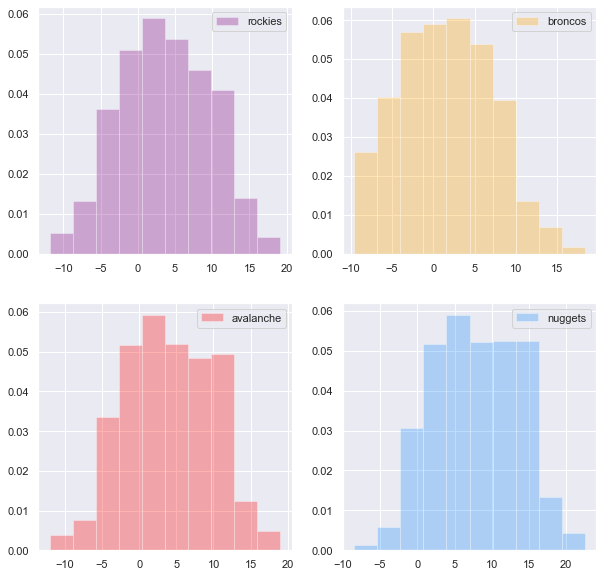

In [9]:
# Ensure hours until sporting events doesn't introduce any anamolies and are somewhat evenly distributed or bell shaped as expected
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(train_X['HOURS_TIL_ROCKIES'].loc[train_X['HOURS_TIL_ROCKIES']!=100000], color='purple', alpha = 0.3, label='rockies', density=True)
plt.legend()
plt.subplot(2,2,2)
plt.hist(train_X['HOURS_TIL_BRONCOS'].loc[train_X['HOURS_TIL_BRONCOS']!=100000], color='orange', alpha=0.3,label='broncos', density=True)
plt.legend()
plt.subplot(2,2,3)
plt.hist(train_X['HOURS_TIL_AVALANCHE'].loc[train_X['HOURS_TIL_AVALANCHE']!=100000], color='red', alpha = 0.3, label='avalanche', density=True)
plt.legend()
plt.subplot(2,2,4)
plt.hist(train_X['HOURS_TIL_NUGGETS'].loc[train_X['HOURS_TIL_NUGGETS']!=100000], color='dodgerblue', alpha = 0.3, label='nuggets', density=True)
plt.legend()
plt.show()

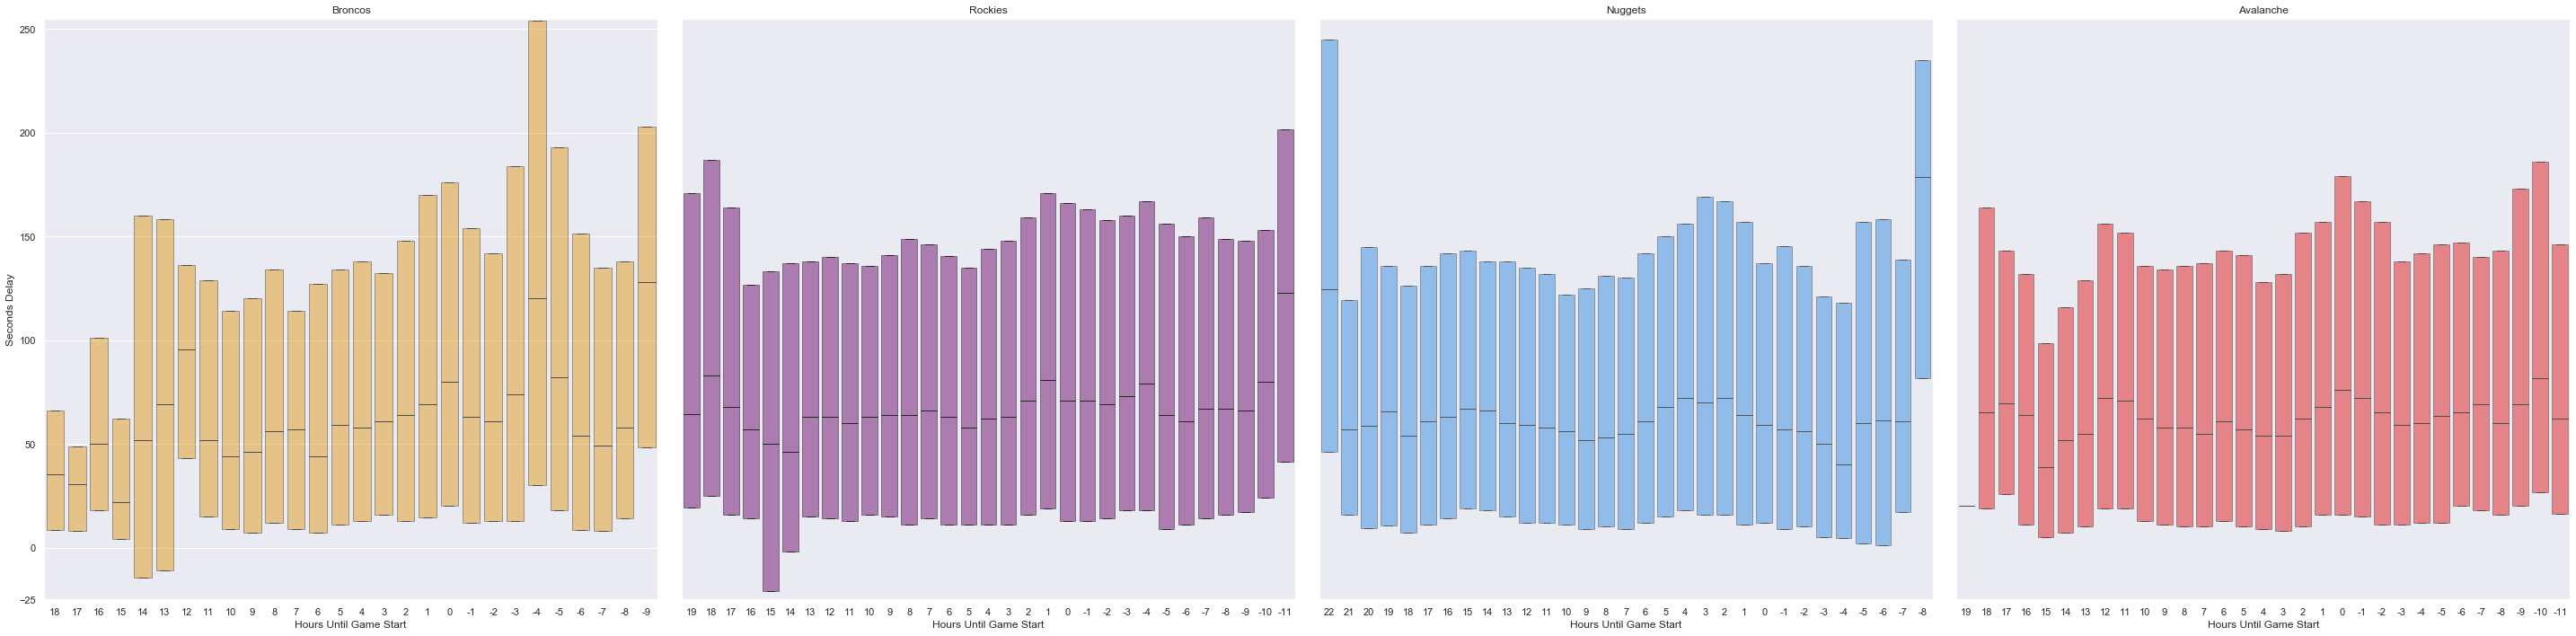

In [10]:
plt.subplots(figsize=(40,10))
col_palette=['orange','purple','dodgerblue','red']
labels=['Broncos','Rockies','Nuggets','Avalanche']
for idx,team in enumerate(['HOURS_TIL_BRONCOS','HOURS_TIL_ROCKIES','HOURS_TIL_NUGGETS','HOURS_TIL_AVALANCHE']):
    plt.subplot(1,4,idx+1)
    ax=sns.boxplot(x=train_X[team].astype('int').loc[train_X[team]!=100000],
                y='DEPARTURE_DELAY',
                data=train_X,
                showfliers=False,
               linewidth=1,
                color=col_palette[idx],
                whis=False)
    plt.title(labels[idx])
    plt.ylabel(' ')
    plt.xlabel('Hours Until Game Start')
    plt.gca().invert_xaxis()
    plt.setp(ax.artists, alpha=.5)
    plt.ylim(-25,255)
    plt.yticks([])
    if idx==0:
        plt.yticks([-25,0, 50, 100, 150,200,250])
        plt.ylabel('Seconds Delay')
    plt.tight_layout()    
plt.show()


Create ordinal weather columns for rain, snow, and ice weather descriptions

| Rain Description                    | Rank        |   
| -----------                         | ----------- |
| Light Drizzle                       | 1           |
| Drizzle                             | 2           |
| Heavy Drizzle                       | 3           |
| Mist                                | 4           |
| Light Rain                          | 5           |
| Rain                                | 6           |
| Heavy Rain                          | 7           |
| Rain Showers                        | 8           |
| Thunderstorm                        | 9           |

| Snow Description                    | Rank        |
| -----------                         | ----------- |
| Light Snow                          | 1           |
| Light Rain and Snow                 | 2           |
| Snow                                | 3           |
| Blowing or Drifting Snow            | 4           |
| Heavy Snow                          | 5           |


| Ice Description                     | Rank        |
| -----------                         | ----------- |
| Light Freezing Drizzle/Freezing Rain| 1           |
| Light Freezing Rain                 | 2           |
| Freezing Drizzle/Freezing Rain      | 3           |
| Hail Showers                        | 4           |


In [11]:
def ordinal_weather (train_X,weather_dict,weather_name):
    
    """
    Creates a singular ordinal weather column for a weather type, such as rain, snow, and ice. 
    
    Parameters:
    train_X: Dataframe including a variety of binary weather indicator columns
    weather_dict: A dictionary of weather types and ordinal value describing a single overarching weather pattern, such as rain, snow, or ice
    weather_name: String indicating weather category to be used to create the ordinal weather field 

    """
    sorted(weather_dict.items(), key=lambda x: x[1])
    weather_field = weather_name+'_ord'
    train_X[weather_field] = 0
    for key, value in weather_dict.items():
        train_X.loc[train_X[key] == 1,weather_field] = value
    
    return train_X

In [12]:
# Create ordinal fields for rain, snow, and hail weather patterns.
rain_dict = {'Light Drizzle':1,
        'Drizzle':2,
        'Heavy Drizzle':3,
        'Mist':4,
        'Light Rain':5,
        'Rain':6,
        'Heavy Rain':7,
        'Rain Showers':8,
        'Thunderstorm':9
       }

snow_dict = {'Light Snow':1,
        'Light Rain And Snow':2,
        'Snow':3,
        'Blowing Or Drifting Snow':4,
        'Heavy Snow':5
       }

hail_dict = {'Light Freezing Drizzle/Freezing Rain':1,
        'Light Freezing Rain':2,
        'Freezing Drizzle/Freezing Rain':3,
        'Hail Showers':4
       }

# Run function to create weather fields
ordinal_weather(train_X,rain_dict, 'rain')
ordinal_weather(train_X,snow_dict, 'snow')
ordinal_weather(train_X,hail_dict, 'hail')

# Remove now unnecessary weather fields from dictionaries made above
weather_list = []
for dict_items in [rain_dict, snow_dict, hail_dict]:
    for key in dict_items.keys():
        weather_list.append(key)
train_X = train_X.drop(weather_list, axis=1)

In [13]:
# Drop additional fields
train_X = train_X.drop(['ARRIVAL','DEPARTURE','TIME_TO_SCH_DEPART','BRONCOS_TIME','DWELL_TIME','NUGGETS_TIME','AVALANCHE_TIME','ROCKIES_TIME'], axis=1)

# Create dummies indicator fields for string columns.
train_X = pd.get_dummies(train_X,columns=['STOPNAME','BRANCH','DIRECTION_NAME','TIME_PERIOD','SERVICE_DAY','CITY','LOOKUP_COUNTY','ROUTE_NUMBER'])

In [14]:
# Function to fill NaN fields
def NA_col_filler (df,column_list,input_value):
    """
    Enters the input value into the NaN values of columns specified.
    
    Parameters:
    -df: dataframe containing columns to update
    -column_list: selected list of columns containing NaN values to update
    -input_value: the value used as the NaN replacement
    
    """
    
    for col in column_list:
        df[col].fillna(input_value, inplace=True)
    return df

In [15]:
# Fill hours til sporting events fields with 100,000
hour_cols = ['HOURS_TIL_BRONCOS','HOURS_TIL_ROCKIES','HOURS_TIL_AVALANCHE','HOURS_TIL_NUGGETS']
NA_col_filler(train_X,hour_cols,100000)

# Set NaN values in FREE_RUNNING to 0.
free_running = ['FREE_RUNNING']
NA_col_filler(train_X,free_running,0)

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,NaN,72.60,31.3,5.5,4.1,NaN,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0


C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


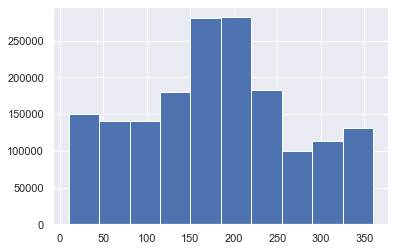

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,NaN,72.60,31.3,5.5,4.1,NaN,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0


In [16]:
plt.hist(train_X['Wind Direction'])
plt.show()

# Set NaN values in Wind Direction to avergae value.
wind_direction = ['Wind Direction']
avg_wind_direction = train_X['Wind Direction'].mean()
NA_col_filler(train_X,wind_direction,avg_wind_direction)

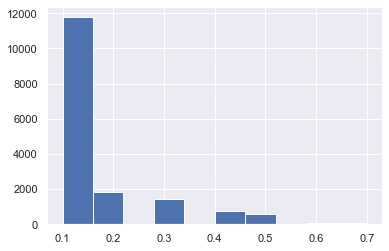

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,0.0,72.60,31.3,5.5,4.1,NaN,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,0.0,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,0.0,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0


In [17]:
plt.hist(train_X['Precipitation'])
plt.show()

# Set NaN values in Precipitation to 0.
precipitation = ['Precipitation']
NA_col_filler(train_X,precipitation,0)

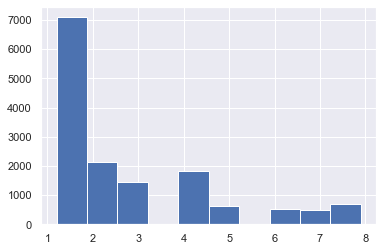

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,0.0,72.60,31.3,5.5,4.1,0.0,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,0.0,72.14,29.7,5.5,5.3,0.0,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,0.0,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,0.0,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,0.0,72.14,29.7,5.5,5.3,0.0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0


In [18]:
plt.hist(train_X['Snow Depth'])
plt.show()

snow_depth = ['Snow Depth']
NA_col_filler(train_X,snow_depth,0)

In [19]:
def nearfill_cols (df, field, timedelta):
    """
    Fills out the selected field based on nearest possible values
    
    Parameters:
    -df: dataframe containing the fields to fill in the event of NaN values
    -field: field entered as a string corresponding to the field to receive the NaN replacement values
    -timedelta: the pandas timedelta unit to operate as a threshold for replacing the nearest NaN
    
    """
    df.sort_values(by=['TIME_SCHEDULED'], inplace=True)
    df.reset_index(inplace=True)
    df =  df[df.columns.drop(list(df.filter(regex='index')))]
    df =  df[df.columns.drop(list(df.filter(regex='level')))]
    merger_df = df[['TIME_SCHEDULED',field]].loc[df[field].notnull()]
    df = pd.merge_asof(df, merger_df, on='TIME_SCHEDULED', direction='nearest', tolerance=pd.Timedelta(timedelta))
    df.drop(df.loc[:, df.columns.str.endswith('_x')], axis=1, inplace=True)
    df.rename(columns={df.columns[-1]: field.upper()}, inplace = True)
    return df

In [20]:
# Fill NA for Relative Humidity, Temperature, and Wind Speed from close records with non null values.
train_X = nearfill_cols(train_X, 'Relative Humidity','5h')
train_X = nearfill_cols(train_X, 'Temperature','3h')
train_X = nearfill_cols(train_X, 'Wind Speed','4h')
train_X = nearfill_cols(train_X, 'Visibility','3h')

In [21]:
# Make all column names lowercase
train_X.columns = [x.lower() for x in train_X.columns]

# Replace spaces in column names with underscores
train_X.columns = train_X.columns.str.replace(' ', '_')


In [22]:
# Create monthly dummy indicator fields
train_X['month'] = train_X['time_scheduled'].dt.month
train_X = pd.get_dummies(train_X,columns = ['month'])

# Create duplicate dataframe for further exploration of input data later
train_X_duplicate = train_X

# Drop time_scheduled field
train_X = train_X.drop(['time_scheduled'], axis=1)

Visualizing correlation across features to identify if specific features are correlated and redundancies can be removed. (https://ajh1143.github.io/Corr/)

def halfHeatMap(df, mirror):

       # Create Correlation df
       corr = df.corr()
       # Plot figsize
       fig, ax = plt.subplots(figsize=(10, 10))
       # Generate Color Map
       colormap = sns.diverging_palette(220, 10, as_cmap=True)

       if mirror == True:
          #Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
          #Apply xticks
          plt.xticks(range(int(len(corr.columns))), int(corr.columns));
          #Apply yticks
          plt.yticks(range(int(len(corr.columns))), int(corr.columns))
          #show plot

       else:
          # Drop self-correlations
          dropSelf = np.zeros_like(corr)
          dropSelf[np.triu_indices_from(dropSelf)] = True
          # Generate Color Map
          colormap = sns.diverging_palette(220, 10, as_cmap=True)
          # Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
          # Apply xticks
          plt.xticks(range(int(len(corr.columns))), int(corr.columns));
          # Apply yticks
          plt.yticks(range(int(len(corr.columns))), int(corr.columns))
       # show plot
       plt.show()

In [21]:
"""
# Create a predictor and target set
train_sample = train_X.sample(n=500000, random_state=42)
y = train_sample.departure_delay 
X = train_sample.drop(['departure_delay'], axis=1)

# Evaluate correlations among features
halfHeatMap(X.astype('int64'), False)
"""

"\n# Create a predictor and target set\ntrain_sample = train_X.sample(n=500000, random_state=42)\ny = train_sample.departure_delay \nX = train_sample.drop(['departure_delay'], axis=1)\n\n# Evaluate correlations among features\nhalfHeatMap(X.astype('int64'), False)\n"

Two models will be tested here - 1) 'full' will include immediately prior train delay lag features and 2) 'reduced' will not. For each model, the following steps will be taken.
1) The dataset train_X will be split into a train, validate, and test set. 
2) A grid search will be run on the training set to select 1-2 values for a max_depth hyper parameter of a random forest regressor. The possible values will be plotted against mean squared error, as specified in the grid search.
3) The model will be re-fitted on the training set and run on the validation test to measure for over-fitting. This comparison will be done by comparing the MSE of the validation set with the prior runs
4) The model will be re-fitted on the training and validation sets and predicted using the test data to obtain final estimates of error

# Full Model including Lag Features

In [23]:
random.seed(24)

# Split data into train, validate, and test
y = train_X.departure_delay
X = train_X.drop(['departure_delay'], axis=1)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.7)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_valid, y_train_valid, test_size=0.8)
"""
#Create a parameter grid for max_depth and instantiate the regressor and grid search
max_depth_values = np.arange(9,30,3)
param_grid = {'max_depth':max_depth_values}
rf_reg_full = RandomForestRegressor(n_estimators=1000, verbose=1)

# Fit grid using training set
full_cv = GridSearchCV(rf_reg_full, param_grid, 'neg_mean_squared_error', cv=3)
full_cv.fit(X_train, y_train)

# Review results from grid search
print(full_cv.best_params_)
print(full_cv.best_score_)
"""

"\n#Create a parameter grid for max_depth and instantiate the regressor and grid search\nmax_depth_values = np.arange(9,30,3)\nparam_grid = {'max_depth':max_depth_values}\nrf_reg_full = RandomForestRegressor(n_estimators=1000, verbose=1)\n\n# Fit grid using training set\nfull_cv = GridSearchCV(rf_reg_full, param_grid, 'neg_mean_squared_error', cv=3)\nfull_cv.fit(X_train, y_train)\n\n# Review results from grid search\nprint(full_cv.best_params_)\nprint(full_cv.best_score_)\n"

Text(0, 0.5, 'Neg Mean Squared Error')

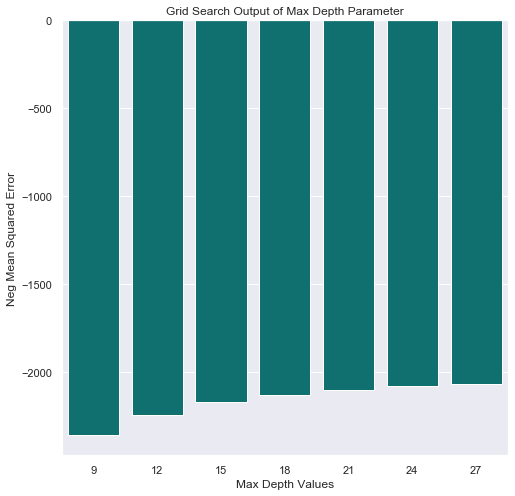

In [396]:
# Plotting grid search results to compare performance across max_depth hyper parameters
plt.figure(figsize=(8,8))
_ = sns.barplot(x=max_depth_values,
                y=full_cv.cv_results_['mean_test_score'],
               color ='teal')
plt.title('Grid Search Output of Max Depth Parameter')
plt.xlabel('Max Depth Values')
plt.ylabel('Neg Mean Squared Error')

In [145]:
# Select ideal max_depth value(s), re-fit on train and run on validation to measure over-fitting
max_depth_full = [9,27] # Enter selected max depth(s) here

rf_reg_full_vldtn_1 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_full[1])
rf_reg_full_vldtn_1.fit(X_train, y_train)
full_vldtn_1_pred = rf_reg_full_vldtn_1.predict(X_train)
full_vldtn_1_pred_mse = mean_squared_error(y_train,full_vldtn_1_pred)

rf_reg_full_vldtn_2 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_full[1])
rf_reg_full_vldtn_2.fit(X_train, y_train)
full_vldtn_2_pred = rf_reg_full_vldtn_2.predict(X_validate)
full_vldtn_2_pred_mse = mean_squared_error(y_validate,full_vldtn_2_pred)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 103.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   45.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 108.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.0min finished


In [146]:
print(full_vldtn_1_pred_mse)
print(full_vldtn_2_pred_mse)

# Comparing the performance of a max_depth==27 model using both validation and training sets indicates that the model is over-fitting with that max_depth.
# Viewing the barchart printout from the gridsearch indicates minimal improvement from 21 onward. Thus, we may want to select 21.
# However, performing a fit and predict on the training and validation sets, respectively, with max_depth of 21 performs worse than a max_depth of 27. 
# Thus, below we are using 27.

783.8042745100844
2109.86778360683


In [24]:
# Run final fit on train + validation and prediction on test
rf_reg_full_test = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=27) # update max depth here
rf_reg_full_test.fit(X_train_valid, y_train_valid)
y_pred_full = rf_reg_full_test.predict(X_test)
y_pred_full_mse = mean_squared_error(y_test,y_pred_full)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 451.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  9.4min finished


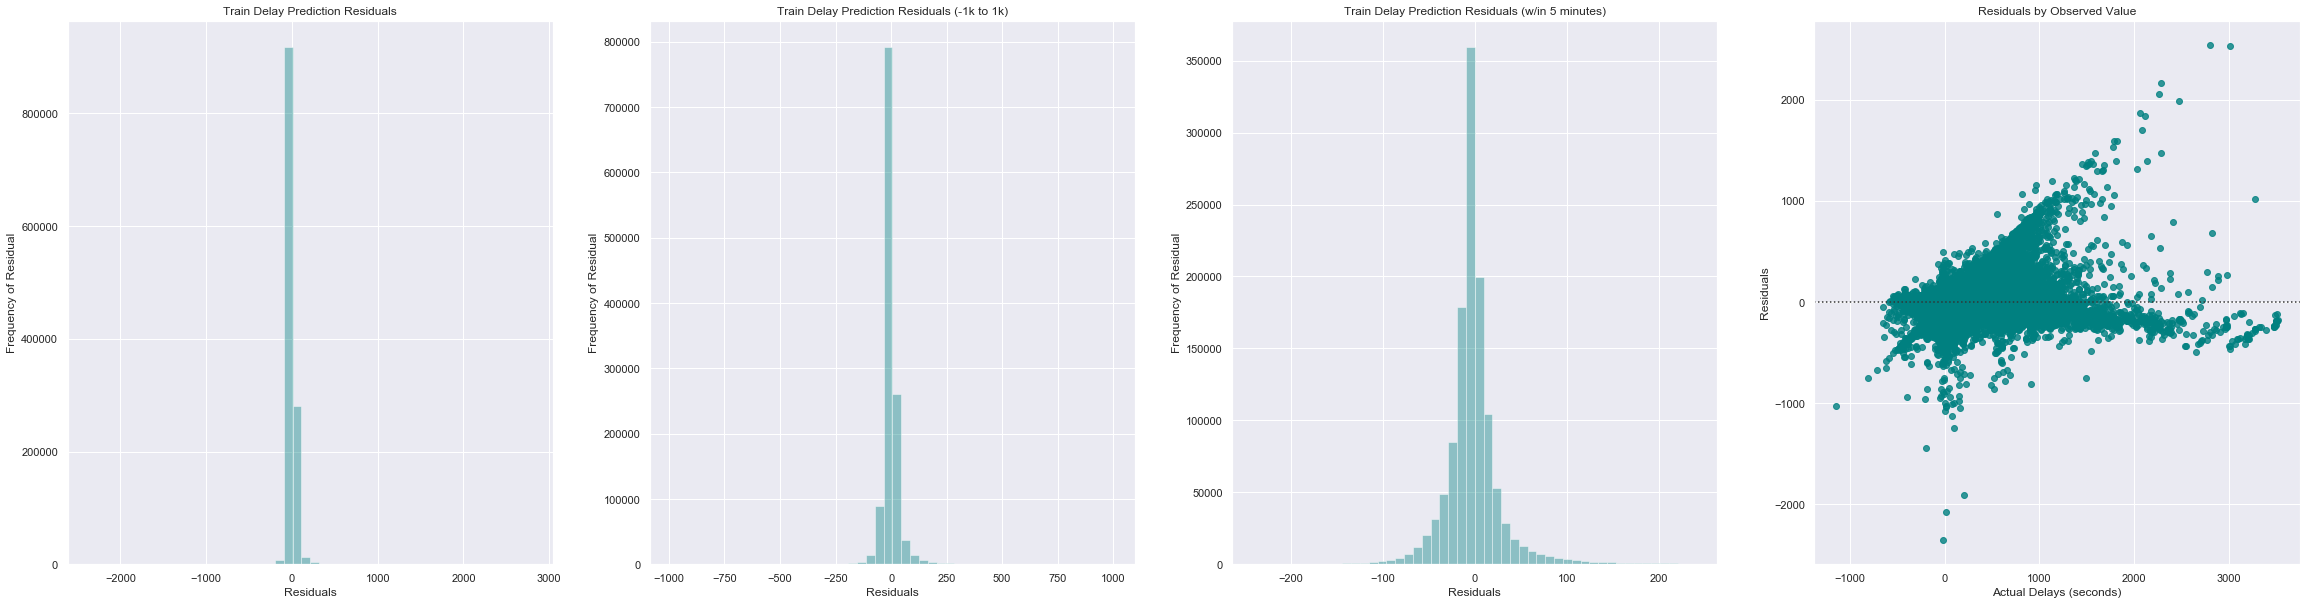

In [25]:
# Measure different time buckets of performance by comparing predicted and actual observations in departure delays
pred_full_df = pd.DataFrame({'y_pred_full':y_pred_full,
                               'y_test':y_test})

pred_full_df['resid'] = pred_full_df['y_test'] - pred_full_df['y_pred_full']

plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
_ = sns.distplot(pred_full_df['resid'],
                kde=False,
                 color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals')

plt.subplot(1,4,2)
_ = sns.distplot(pred_full_df['resid'].loc[(pred_full_df['resid']<=1000) & (pred_full_df['resid']>=-1000)],
                kde=False,
                 color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (-1k to 1k)')

plt.subplot(1,4,3)
_ = sns.distplot(pred_full_df['resid'].loc[(pred_full_df['resid']<=240) & (pred_full_df['resid']>=-240)],
                kde=False,
                 color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (w/in 5 minutes)')

plt.subplot(1,4,4)
_ = sns.residplot(x='y_test',
                 y='resid',
                 data=pred_full_df,
                 color='teal')
plt.xlabel('Actual Delays (seconds)')
plt.ylabel('Residuals')
plt.title('Residuals by Observed Value')


plt.show()

In [ ]:
delay_min, delay_max = pred_full_df['y_test'].min(), pred_full_df['y_test'].max() 
print(delay_min)
print(delay_max)

In [26]:
# Assuming delays are relatively normal, explore reasonable bin lengths separately in early and late departures
print('Early Departures')
print(pred_full_df.resid.loc[pred_full_df.y_test<0].describe().apply(lambda x: format(x, 'f')))
print(" ")
print('Late Departures')
print(pred_full_df.resid.loc[pred_full_df.y_test>=0].describe().apply(lambda x: format(x, 'f')))

# Set up bin ranges and labels
bins = [-15*60,
        -5*60,
        -2*60,
        0,
        2*60,
        5*60,
        10*60,
        15*60,
        20*60,
        30*60,
        60*60]
labels = ['15-5 min early',
          '5-2 min early',
          '<2 min early',
          '<2 min late',
          '2-5 min late',
          '5-10 min late',
          '10-15 min late',
          '15-20 min late',
          '20-30 min late',
          '30-60 min late']

print(' ')
print('Delayed Departure Bins')
for i,label in enumerate(labels):
    print(label+':' )
    print(bins[i], ' - ',bins[i+1])
    print(' ')

# Created delay bins for both the observed and predicted second delay durations with minute labels
pred_full_df['delay_bins'] = pd.cut(x=pred_full_df['y_test'], bins=bins, labels=labels)
pred_full_df['prediction_bins'] = pd.cut(x=pred_full_df['y_pred_full'], bins=bins, labels=labels)

# Flag records corresponding to a match bin value between the observed and predicted
pred_full_df.loc[pred_full_df['delay_bins'] == pred_full_df['prediction_bins'], 'match'] = 1
pred_full_df.loc[pred_full_df['delay_bins'] != pred_full_df['prediction_bins'], 'match'] = 0

display((pred_full_df).head(25))

Early Departures
count    202903.000000
mean        -17.824163
std          33.122205
min       -2357.922000
25%         -27.349184
50%          -8.822977
75%          -0.499750
max         481.700000
Name: resid, dtype: object
 
Late Departures
count    1026521.000000
mean           2.867091
std           46.142843
min        -2081.764000
25%          -11.978905
50%           -2.500037
75%            9.794976
max         2784.473957
Name: resid, dtype: object
 
Delayed Departure Bins
15-5 min early:
-900  -  -300
 
5-2 min early:
-300  -  -120
 
<2 min early:
-120  -  0
 
<2 min late:
0  -  120
 
2-5 min late:
120  -  300
 
5-10 min late:
300  -  600
 
10-15 min late:
600  -  900
 
15-20 min late:
900  -  1200
 
20-30 min late:
1200  -  1800
 
30-60 min late:
1800  -  3600
 


,y_pred_full,y_test,resid,delay_bins,prediction_bins,match
1403219,139.255921,134.0,-5.255921,2-5 min late,2-5 min late,1.0
7596,63.224149,51.0,-12.224149,<2 min late,<2 min late,1.0
1312215,-20.684351,-20.0,0.684351,<2 min early,<2 min early,1.0
666765,13.563152,154.0,140.436848,2-5 min late,<2 min late,0.0
81632,67.296863,68.0,0.703137,<2 min late,<2 min late,1.0
157703,22.550886,13.0,-9.550886,<2 min late,<2 min late,1.0
398186,72.517638,81.0,8.482362,<2 min late,<2 min late,1.0
29221,43.237245,48.0,4.762755,<2 min late,<2 min late,1.0
1663283,29.362458,36.0,6.637542,<2 min late,<2 min late,1.0
188031,272.575657,365.0,92.424343,5-10 min late,2-5 min late,0.0


<function matplotlib.pyplot.show(*args, **kw)>

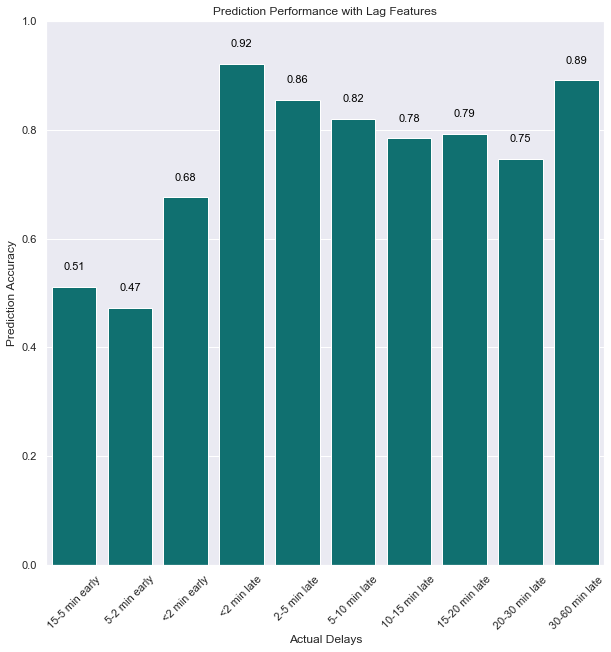

In [27]:
# Plot performance by time bucket and annotate bar with prediction accuracy
full_performance_buckets = pred_full_df.groupby(by='delay_bins', as_index=False).agg({'match':['count','sum']})
full_performance_buckets.columns = full_performance_buckets.columns.droplevel()
full_performance_buckets['accuracy'] = full_performance_buckets['sum'] / full_performance_buckets['count']
full_performance_buckets.head(10)

_ = plt.figure(figsize=(10,10))
g = sns.barplot(x='',
                y='accuracy',
                data=full_performance_buckets,
                color='teal')
ax=g
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.title('Prediction Performance with Lag Features')
plt.xlabel('Actual Delays')
plt.ylim(0,1)
plt.ylabel('Prediction Accuracy')
plt.xticks(rotation=45)
plt.show

# Reduced Model without Lag Features

In [22]:
random.seed(24)

# Split data into train, validate, and test
y = train_X.departure_delay
X = train_X[train_X.columns.drop(list(train_X.filter(regex='prior_departure_delay')))]
X = X.drop(['departure_delay'], axis=1)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.7)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_valid, y_train_valid, test_size=0.8)

# Create a parameter grid for max_depth and instantiate the regressor and grid search
max_depth_values = np.arange(9,31,3)
param_grid = {'max_depth':max_depth_values}
rf_reg_reduced = RandomForestRegressor(n_estimators=1000, verbose=1)

# Fit grid using training set
reduced_cv = GridSearchCV(rf_reg_reduced, param_grid, 'neg_mean_squared_error', cv=3)

# Sample the training set for improved gridsearch runtime
idx = np.random.choice(np.arange(len(X_train)),5000, replace=True)
reduced_cv.fit(X_train.iloc[idx], y_train.iloc[idx])

# Review results from grid search
print(reduced_cv.best_params_)
print(reduced_cv.best_score_)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   20.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

{'max_depth': 30}
-16362.444825459546


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished


Text(0, 0.5, 'Neg Mean Squared Error')

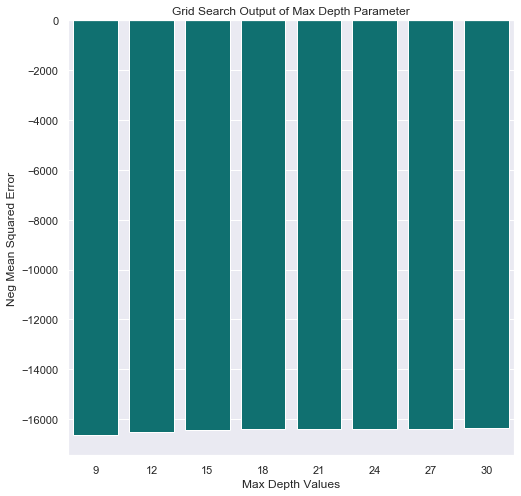

In [429]:
# Plotting grid search results to compare performance across max_depth hyper parameters
max_depth_values = np.arange(9,31,3)
plt.figure(figsize=(8,8))
_ = sns.barplot(x=max_depth_values,
                y=reduced_cv.cv_results_['mean_test_score'],
               color ='teal')
plt.title('Grid Search Output of Max Depth Parameter')
plt.xlabel('Max Depth Values')
plt.ylabel('Neg Mean Squared Error')
# The below comparison does not show significant incremental changes in performance from 18 forward. A max_depth of 18 will be selected and verified for over-fitting below.

In [24]:
# Select ideal max_depth value(s), re-fit on train and run on validation to measure over-fitting
max_depth_reduced = [18, 9] # Enter selected max depth(s) here

rf_reg_reduced_vldtn_1 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[0])
rf_reg_reduced_vldtn_1.fit(X_train, y_train)
reduced_vldtn_1_pred = rf_reg_reduced_vldtn_1.predict(X_train)
reduced_vldtn_1_pred_mse = mean_squared_error(y_train,reduced_vldtn_1_pred)

rf_reg_reduced_vldtn_2 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[0])
rf_reg_reduced_vldtn_2.fit(X_train, y_train)
reduced_vldtn_2_pred = rf_reg_reduced_vldtn_2.predict(X_validate)
reduced_vldtn_2_pred_mse = mean_squared_error(y_validate,reduced_vldtn_2_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 38.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 33.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.2min finished


In [25]:
print(reduced_vldtn_1_pred_mse)
print(reduced_vldtn_2_pred_mse)


8935.454845256187
15926.521121774113


In [27]:
rf_reg_reduced_vldtn_1 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[1])
rf_reg_reduced_vldtn_1.fit(X_train, y_train)
reduced_vldtn_1_pred = rf_reg_reduced_vldtn_1.predict(X_train)
reduced_vldtn_1_pred_mse = mean_squared_error(y_train,reduced_vldtn_1_pred)

rf_reg_reduced_vldtn_2 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[1])
rf_reg_reduced_vldtn_2.fit(X_train, y_train)
reduced_vldtn_2_pred = rf_reg_reduced_vldtn_2.predict(X_validate)
reduced_vldtn_2_pred_mse = mean_squared_error(y_validate,reduced_vldtn_2_pred)

print(reduced_vldtn_1_pred_mse)
print(reduced_vldtn_2_pred_mse)


# Using the validation set for an additional measure of over-fitting, the gridsearch recommendation of 21 shows generalization than  
# a max_depth of 9 despite over-fitting. Thus, 21 will be selected here.

15857.116650547194
17074.614768820826


In [28]:
# Run final fit on train + validation and prediction on test
rf_reg_reduced_test = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[0]) # update max depth here
rf_reg_reduced_test.fit(X_train_valid, y_train_valid)
y_pred_reduced = rf_reg_reduced_test.predict(X_test)
y_pred_reduced_mse = mean_squared_error(y_test,y_pred_reduced)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 279.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 10.2min finished


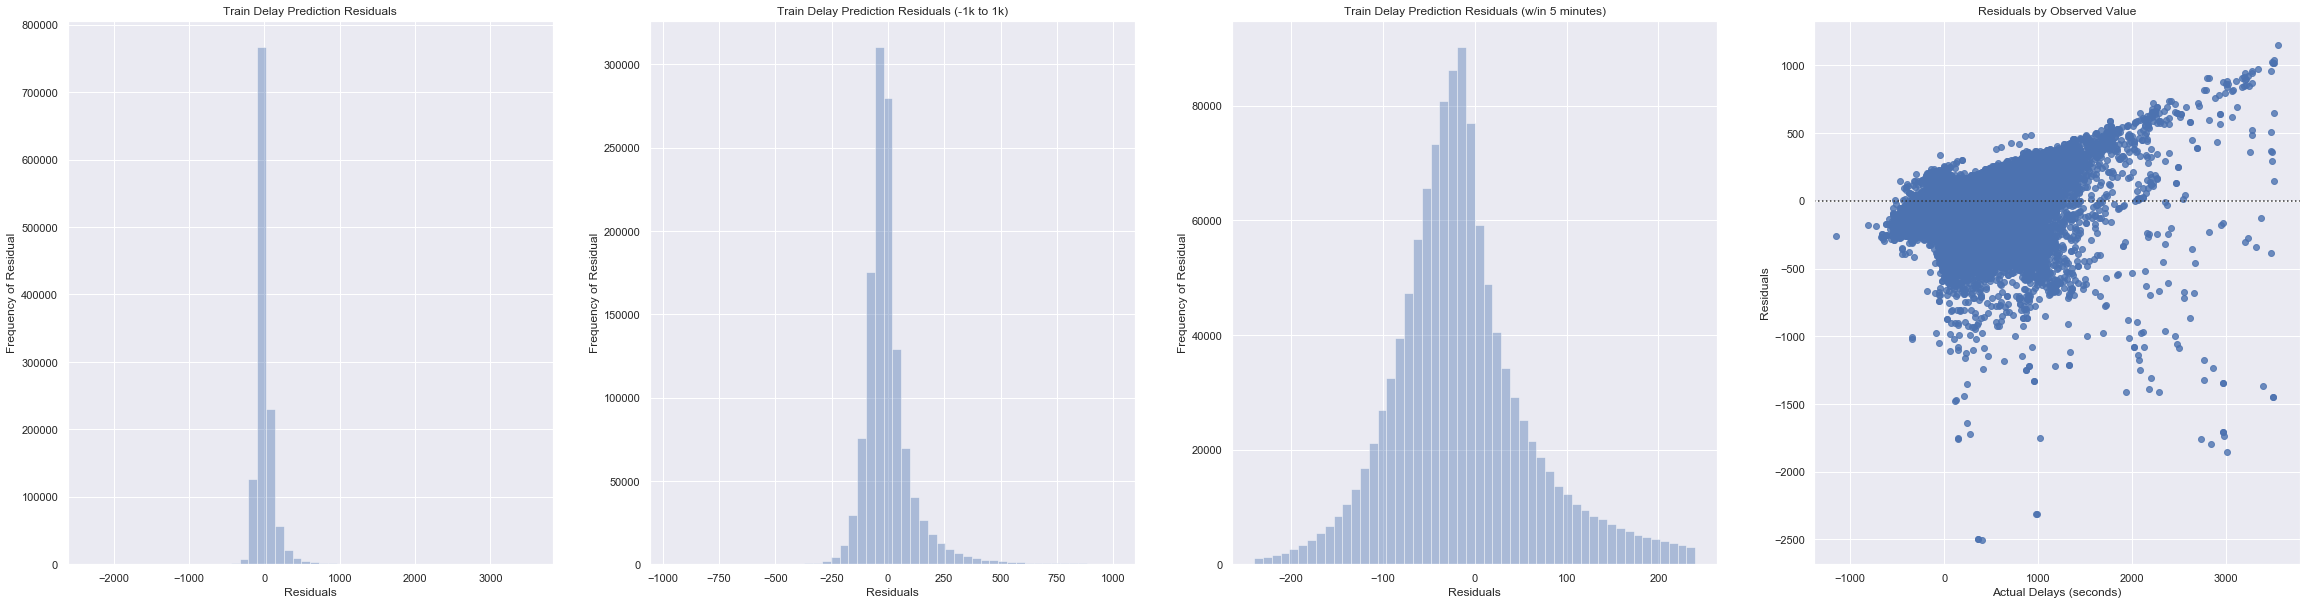

In [29]:
# Measure different time buckets of performance by comparing predicted and actual observations in departure delays
pred_reduced_df = pd.DataFrame({'y_pred_reduced':y_pred_reduced,
                               'y_test':y_test})

pred_reduced_df['resid'] = pred_reduced_df['y_test'] - pred_reduced_df['y_pred_reduced']

plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
_ = sns.distplot(pred_reduced_df['resid'],
                kde=False,
                color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals')

plt.subplot(1,4,2)
_ = sns.distplot(pred_reduced_df['resid'].loc[(pred_reduced_df['resid']<=1000) & (pred_reduced_df['resid']>=-1000)],
                kde=False,
                color='teal)
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (-1k to 1k)')

plt.subplot(1,4,3)
_ = sns.distplot(pred_reduced_df['resid'].loc[(pred_reduced_df['resid']<=240) & (pred_reduced_df['resid']>=-240)],
                kde=False,
                color='teal)
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (w/in 5 minutes)')

plt.subplot(1,4,4)
_ = sns.residplot(x='y_test',
                 y='resid',
                 data=pred_reduced_df,
                color='teal)
plt.xlabel('Actual Delays (seconds)')
plt.ylabel('Residuals')
plt.title('Residuals by Observed Value')


plt.show()

In [53]:
delay_min, delay_max = pred_reduced_df['y_test'].min(), pred_reduced_df['y_test'].max() 
print(delay_min)
print(delay_max)

-808.0
3550.0


In [31]:
# Assuming delays are relatively normal, explore reasonable bins separately in early and late departures
print('Early Departures')
print(pred_reduced_df.resid.loc[pred_reduced_df.y_test<0].describe().apply(lambda x: format(x, 'f')))
print(" ")
print('Late Departures')
print(pred_reduced_df.resid.loc[pred_reduced_df.y_test>=0].describe().apply(lambda x: format(x, 'f')))

# Set up bin ranges and labels
bins = [-15*60,
        -5*60,
        -2*60,
        0,
        2*60,
        5*60,
        10*60,
        15*60,
        20*60,
        30*60,
        60*60]
labels = ['15-5 min early',
          '5-2 min early',
          '<2 min early',
          '<2 min late',
          '2-5 min late',
          '5-10 min late',
          '10-15 min late',
          '15-20 min late',
          '20-30 min late',
          '30-60 min late']

print(' ')
print('Delayed Departure Bins')
for i,label in enumerate(labels):
    print(label+':' )
    print(bins[i], ' - ',bins[i+1])
    print(' ')

# Created delay bins for both the observed and predicted second delay durations with minute labels
pred_reduced_df['delay_bins'] = pd.cut(x=pred_reduced_df['y_test'], bins=bins, labels=labels)
pred_reduced_df['prediction_bins'] = pd.cut(x=pred_reduced_df['y_pred_reduced'], bins=bins, labels=labels)

# Flag records corresponding to a match bin value between the observed and predicted
pred_reduced_df.loc[pred_reduced_df['delay_bins'] == pred_reduced_df['prediction_bins'], 'match'] = 1
pred_reduced_df.loc[pred_reduced_df['delay_bins'] != pred_reduced_df['prediction_bins'], 'match'] = 0

display((pred_reduced_df).head(25))

Early Departures
count    202735.000000
mean        -78.622989
std          56.990280
min       -1327.652289
25%        -102.501353
50%         -67.447062
75%         -41.970934
max         233.379067
Name: resid, dtype: object
 
Late Departures
count    1026689.000000
mean          15.474040
std          124.761013
min        -2318.867117
25%          -43.534863
50%           -8.955719
75%           41.250557
max         3534.552934
Name: resid, dtype: object
 
Delayed Departure Bins
15-5 min early:
-900  -  -300
 
5-2 min early:
-300  -  -120
 
<2 min early:
-120  -  0
 
<2 min late:
0  -  120
 
2-5 min late:
120  -  300
 
5-10 min late:
300  -  600
 
10-15 min late:
600  -  900
 
15-20 min late:
900  -  1200
 
20-30 min late:
1200  -  1800
 
30-60 min late:
1800  -  3600
 


,y_pred_reduced,y_test,resid,delay_bins,prediction_bins,match
1699515,110.631573,182.0,71.368427,2-5 min late,<2 min late,0.0
738484,27.005458,-8.0,-35.005458,<2 min early,<2 min late,0.0
876438,202.157996,350.0,147.842004,5-10 min late,2-5 min late,0.0
220972,25.233789,117.0,91.766211,<2 min late,<2 min late,1.0
1525806,172.152395,149.0,-23.152395,2-5 min late,2-5 min late,1.0
1000047,13.129150,-51.0,-64.129150,<2 min early,<2 min late,0.0
1171546,90.386053,52.0,-38.386053,<2 min late,<2 min late,1.0
1744893,138.318396,373.0,234.681604,5-10 min late,2-5 min late,0.0
1250402,130.128068,76.0,-54.128068,<2 min late,2-5 min late,0.0
203947,46.659308,34.0,-12.659308,<2 min late,<2 min late,1.0


TypeError: 'list' object is not callable

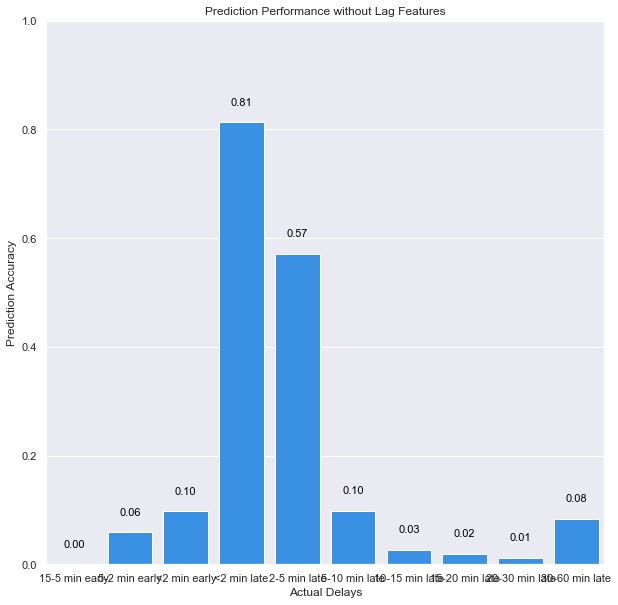

In [424]:
# Plot performance by time bucket and annotate bar with prediction accuracy
reduced_performance_buckets = pred_reduced_df.groupby(by='delay_bins', as_index=False).agg({'match':['count','sum']})
reduced_performance_buckets.columns = reduced_performance_buckets.columns.droplevel()
reduced_performance_buckets['accuracy'] = reduced_performance_buckets['sum'] / reduced_performance_buckets['count']
reduced_performance_buckets.head(10)

_ = plt.figure(figsize=(10,10))
g = sns.barplot(x='',
                y='accuracy',
                data=reduced_performance_buckets,
                color='dodgerblue')
ax=g
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20), textcoords='offset points')
plt.title('Prediction Performance without Lag Features')
plt.xlabel('Actual Delays')
plt.ylim(0,1)
plt.ylabel('Prediction Accuracy')
plt.xticks(rotation=45)
plt.show()



In [ ]:
# The above shows rather poor performance for predicting train delays without lag features. Since drastic delays are generally caused by immediate complications,
# such as employee issues, sudden mechanical issues, etc. these root causes nor the symptoms of them would be availabe in this dataset.

# Compare Runtime for a Minute's Worth of New Records Across Hyperparameter Possibilities

In [167]:
# Identify busiest minute of data
minute_df = train_X_duplicate[['time_scheduled','departure_delay']].set_index('time_scheduled')

minute_df.resample('min').count().sort_values(by='departure_delay',ascending=False).head(1)

# The busiest minute in the dataset is between '2019-08-30 16:13:00' and '2019-08-30 16:13:59'

,departure_delay
time_scheduled,
2019-08-30 16:13:00,18


In [185]:
# New training and testing sets will be created with the testing set corresponding to the 18 rows in the above minute
random.seed(24)

test_idx = train_X_duplicate.loc[(train_X_duplicate.time_scheduled>='2019-08-30 16:13:00') & (train_X_duplicate.time_scheduled<='2019-08-30 16:14:59')].index
training_set_df = train_X.loc[~train_X.index.isin(test_idx)].sample(n=5000)

# Create training and testing sets
X_train = training_set_df.drop(['departure_delay'],axis=1)
y_train = training_set_df['departure_delay']
X_test = train_X.iloc[test_idx].drop(['departure_delay'],axis=1)

# Instantiate regressor(s) and train each
time_comp_18 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=18) 
time_comp_18.fit(X_train, y_train)
time_comp_27 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=27) 
time_comp_27.fit(X_train, y_train)

%timeit -t time_comp_18.predict(X_test)
%timeit -t time_comp_27.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


ValueError: stmt is neither a string nor callable